## Imports of Packages

In [1]:
# Importing required packages
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)

import marshal

In [3]:
s = open(r"C:\Users\Abdul Rehaman\Downloads\pyc files\Model_supporting_code.pyc", 'rb')
s.seek(16)  # go past first eight bytes
code_obj = marshal.load(s)
exec(code_obj)

## Function to Calcualte VIF

In [4]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

## Import Dataset

In [5]:
df = pd.read_excel(r"C:\Users\Abdul Rehaman\Desktop\Model Refresh Feb 2023\Masala_Oats_Dataset.xlsx", sheet_name = 'Dataset')
df

,DATE,Month_Year,FRIDAY,MONDAY,SATURDAY,SUNDAY,THURSDAY,TUESDAY,WEDNESDAY,ISWEEKEND,...,YOUTUBE_NET_SENTIMENT_MENTIONS,AUTOMATIC_ALERTS_NET_SENTIMENT_MENTIONS,WORDPRESS_NET_SENTIMENT_MENTIONS,BLOG_COMMENTS_NET_SENTIMENT_MENTIONS,FORUMS_NET_SENTIMENT_MENTIONS,FACEBOOK_NET_SENTIMENT_MENTIONS,POSITIVE_MENTIONS,NEGATIVE_MENTIONS,NEUTRAL_MENTIONS,NET_SENTIMENT_MENTIONS
0,2020-06-01,2020-06,0,1,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.00,0,0,0,0.000000
1,2020-06-02,2020-06,0,0,0,0,0,1,0,0,...,0.0,0,0,0,0.0,0.00,1,1,1,0.000000
2,2020-06-03,2020-06,0,0,0,0,0,0,1,0,...,0.0,0,0,0,0.0,0.00,2,0,3,0.400000
3,2020-06-04,2020-06,0,0,0,0,1,0,0,0,...,0.0,0,0,0,0.0,0.00,0,0,1,0.000000
4,2020-06-05,2020-06,1,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,0.00,2,0,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2022-12-27,2022-12,0,0,0,0,0,1,0,0,...,0.0,0,0,0,0.0,0.00,20,0,1,0.952381
940,2022-12-28,2022-12,0,0,0,0,0,0,1,0,...,0.0,0,0,0,0.0,0.50,14,0,4,0.777778
941,2022-12-29,2022-12,0,0,0,0,1,0,0,0,...,0.0,0,0,0,0.0,0.75,22,0,4,0.846154
942,2022-12-30,2022-12,1,0,0,0,0,0,0,0,...,0.0,0,0,0,0.0,1.00,25,0,27,0.480769


In [6]:
df['OVERALL_VOLUME'].sum()

1647476.6365646035

In [7]:
df1 = df.fillna(0)

## Function to Create additional lags apart from lags in dataset

In [8]:
def create_lags(df, cols, lag_list):
    
    for i in cols:
        for j in lag_list:
            df[i+'_LAG_'+str(j)] = df[i].shift(j)
            
    return df

In [9]:
long_lag = [1,3,5,7,10,14,21,30]
mid_lag = [7,10,21,30]


df1['FACEBOOK/INSTAGRAM_SPEND'] = df1['FACEBOOK_SPEND']+df1['INSTAGRAM_SPEND']
long_lag_cols = ['FACEBOOK/INSTAGRAM_SPEND']
mid_lag_cols = ['TV_spend']

df1 = create_lags(df1, long_lag_cols, long_lag)
df1 = create_lags(df1, mid_lag_cols, mid_lag)

In [10]:
iteration=0

## Function to fit the model and generate results

In [11]:
def generate_model_results(df, iterartion):
    
    x = df.drop(['OVERALL_VOLUME', 'DATE'], axis =1)
#     x.insert(0, "INTERCEPT" , 1)
    y=df[["OVERALL_VOLUME"]]

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)
    X_train.replace([np.inf, -np.inf], 0, inplace=True)

    model = sm.OLS(y_train, X_train).fit()
    Vif = calc_vif(x)

    result_df = pd.DataFrame()
    result_df['FEATURE'] = x.columns
    result_df['COEFF'] = list(model.summary2().tables[1]['Coef.'])
    result_df['P_VALUE'] = list(round(model.pvalues, 5))
      
    model_iteration_new=pd.DataFrame()
    model_iteration_all=pd.DataFrame()
    model_columns_used=pd.DataFrame()
    model_score=pd.DataFrame()
    
    sum_df = pd.DataFrame(x.sum(axis = 0, skipna = True)).reset_index()
    sum_df.columns =  ['FEATURE', 'SUM']
    sum_df = sum_df[sum_df['FEATURE'].isin(list(result_df['FEATURE'].unique()))].reset_index(drop= True)
    
    result_df = result_df.merge(sum_df, left_on = 'FEATURE', right_on = 'FEATURE', how = 'left')
    result_df = result_df.merge(Vif,left_on = 'FEATURE', right_on = 'variables', how = 'left')
    result_df = result_df.drop(columns = 'variables')
    y_test['PREDICTIONS'] =  model.predict(X_test)

    print('########## RMSE ###########')
    y_test['squared_error'] = (y_test['OVERALL_VOLUME'] - y_test['PREDICTIONS'])**2
    rmse = np.sqrt(y_test['squared_error'].sum()/len(y_test))
    print(rmse)

    print('########## MAPE ###########')
    y_test['error'] = abs(y_test['OVERALL_VOLUME'] - y_test['PREDICTIONS'])
    mape = (sum(y_test['error']/y_test['OVERALL_VOLUME']))/len(y_test)
    print(mape)

    print("####### PRMSE ##############")

    prmse = rmse/y_test['OVERALL_VOLUME'].mean()
    print(prmse)

    adj_rsq = model.rsquared_adj
    rsq = model.rsquared
    print("rsquared\n",model.rsquared)
    print("rsquared_adj\n",model.rsquared_adj)

    y_test.drop(['squared_error', 'error'], axis =1, inplace = True)

    Total_vol = y['OVERALL_VOLUME'].sum()
    
#     result_df = pd.merge(result_df, Vif, on ='FEATURE',how='left')
    
#     iterartion+=1
    model_columns_used=model_columns_used.append(pd.DataFrame({'iteration':iterartion,'columns_list':list(df.columns)})).reset_index(drop='yes')
    result_df['iteration']=iterartion
    model_iteration_all=model_iteration_all.append(result_df).reset_index(drop='yes')
    model_score=model_score.append(pd.DataFrame({'iteration':iterartion,'RMSE': [rmse], 'MAPE': [mape], 'PRMSE': [prmse] , 'ADJ_RSQUARED': [adj_rsq] , 'RSQUARED': [rsq]}).T.reset_index()).reset_index(drop='yes')
    
    return result_df, model, x, y_test

In [12]:
df1.columns.to_list()

['DATE',
 'Month_Year',
 'FRIDAY',
 'MONDAY',
 'SATURDAY',
 'SUNDAY',
 'THURSDAY',
 'TUESDAY',
 'WEDNESDAY',
 'ISWEEKEND',
 'ISWEEKDAY',
 'AMS_DISPLAY_CLICKS',
 'AMS_SEARCH_CLICKS',
 'AMS_SEARCH_SP_CLICKS',
 'DISPLAY_CLICKS',
 'FACEBOOK_CLICKS',
 'G_ADWORDS_CLICKS',
 'INSTAGRAM_CLICKS',
 'YOUTUBE_CLICKS',
 'AMS_DISPLAY_IMPRESSIONS',
 'AMS_SEARCH_IMPRESSIONS',
 'AMS_SEARCH_SP_IMPRESSIONS',
 'DISPLAY_IMPRESSIONS',
 'FACEBOOK_IMPRESSIONS',
 'G_ADWORDS_IMPRESSIONS',
 'INSTAGRAM_IMPRESSIONS',
 'YOUTUBE_IMPRESSIONS',
 'AMS_DISPLAY_SPEND',
 'AMS_SEARCH_SPEND',
 'AMS_SEARCH_SP_SPEND',
 'DISPLAY_SPEND',
 'FACEBOOK_SPEND',
 'G_ADWORDS_SPEND',
 'INSTAGRAM_SPEND',
 'YOUTUBE_SPEND',
 'JBP_AMAZON',
 'JBP_FLIPKART',
 'JBP_BIG_BASKET',
 'PLA_SPENDS',
 'PCA_SPENDS',
 'JBP_FLIPKART_TRUE',
 'Brand',
 'TV_spend',
 'AMS_DISPLAY_SPEND_LAG_1',
 'AMS_DISPLAY_SPEND_LAG_3',
 'AMS_DISPLAY_SPEND_LAG_5',
 'AMS_DISPLAY_SPEND_LAG_7',
 'AMS_DISPLAY_SPEND_LAG_10',
 'AMS_DISPLAY_SPEND_LAG_14',
 'AMS_DISPLAY_SPEND_LAG_2

<Axes: >

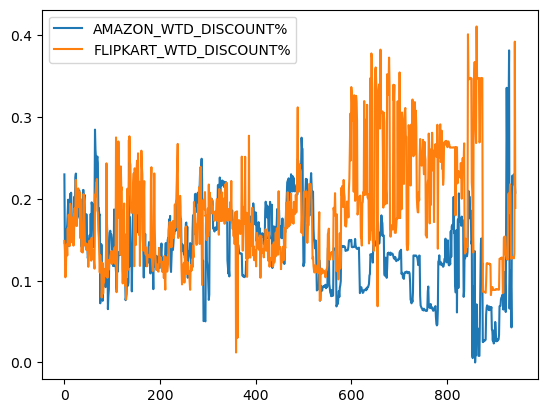

In [13]:
df1[['AMAZON_WTD_DISCOUNT%', 'FLIPKART_WTD_DISCOUNT%',]].plot(kind = 'line')

## Function to select subset of columns from dataset

In [14]:
def create_features(df):
    
    new_df = df.copy()

    model_cols = [          'DATE', 
                            'ISWEEKEND',
                  
#                             'AMS_DISPLAY_SPEND',
                             'AMS_SEARCH_SPEND',
                             'AMS_SEARCH_SP_SPEND',
#                              'DISPLAY_SPEND',
#                              'FACEBOOK_SPEND',
#                              'G_ADWORDS_SPEND',
#                              'INSTAGRAM_SPEND',
#                              'YOUTUBE_SPEND',
                                               
                             'JBP_AMAZON',
                             'JBP_BIG_BASKET',
                  
                             'PLA_SPENDS',
#                              'PCA_SPENDS',
                             'JBP_FLIPKART_TRUE',

#                               'TV_spend',
                  
#                             'AMS_DISPLAY_SPEND_LAG_1',
                             'AMS_DISPLAY_SPEND_LAG_3',
#                              'AMS_DISPLAY_SPEND_LAG_5',
#                              'AMS_DISPLAY_SPEND_LAG_7',
#                              'AMS_DISPLAY_SPEND_LAG_10',
#                              'AMS_DISPLAY_SPEND_LAG_14',
#                              'AMS_DISPLAY_SPEND_LAG_21',
#                              'AMS_DISPLAY_SPEND_LAG_30',
                  
#                              'AMS_SEARCH_SPEND_LAG_1',
#                              'AMS_SEARCH_SPEND_LAG_3',
#                              'AMS_SEARCH_SPEND_LAG_5',
#                              'AMS_SEARCH_SPEND_LAG_7',
#                              'AMS_SEARCH_SPEND_LAG_10',
#                              'AMS_SEARCH_SPEND_LAG_14',
#                              'AMS_SEARCH_SPEND_LAG_21',
#                              'AMS_SEARCH_SPEND_LAG_30',
#                              'AMS_SEARCH_SP_SPEND_LAG_1',
#                              'AMS_SEARCH_SP_SPEND_LAG_3',
#                              'AMS_SEARCH_SP_SPEND_LAG_5',
#                              'AMS_SEARCH_SP_SPEND_LAG_7',
#                              'AMS_SEARCH_SP_SPEND_LAG_10',
#                              'AMS_SEARCH_SP_SPEND_LAG_14',
#                              'AMS_SEARCH_SP_SPEND_LAG_21',
#                              'AMS_SEARCH_SP_SPEND_LAG_30',
                  
#                              'DISPLAY_SPEND_LAG_1',
#                              'DISPLAY_SPEND_LAG_3',
#                              'DISPLAY_SPEND_LAG_5',
#                              'DISPLAY_SPEND_LAG_7',
#                              'DISPLAY_SPEND_LAG_10',
#                              'DISPLAY_SPEND_LAG_14',
                             'DISPLAY_SPEND_LAG_21',
#                              'DISPLAY_SPEND_LAG_30',
                  
#                              'FACEBOOK_SPEND_LAG_1',
#                              'FACEBOOK_SPEND_LAG_3',
#                              'FACEBOOK_SPEND_LAG_5',
#                              'FACEBOOK_SPEND_LAG_7',
#                              'FACEBOOK_SPEND_LAG_10',
#                              'FACEBOOK_SPEND_LAG_14',
#                              'FACEBOOK_SPEND_LAG_21',
#                              'FACEBOOK_SPEND_LAG_30',
                  
#                              'G_ADWORDS_SPEND_LAG_1',
#                              'G_ADWORDS_SPEND_LAG_3',
#                              'G_ADWORDS_SPEND_LAG_5',
#                              'G_ADWORDS_SPEND_LAG_7',
#                              'G_ADWORDS_SPEND_LAG_10',
#                              'G_ADWORDS_SPEND_LAG_14',
#                              'G_ADWORDS_SPEND_LAG_21',
#                              'G_ADWORDS_SPEND_LAG_30',
                  
#                              'INSTAGRAM_SPEND_LAG_1',
#                              'INSTAGRAM_SPEND_LAG_3',
#                              'INSTAGRAM_SPEND_LAG_5',
#                              'INSTAGRAM_SPEND_LAG_7',
#                              'INSTAGRAM_SPEND_LAG_10',
#                              'INSTAGRAM_SPEND_LAG_14',
#                              'INSTAGRAM_SPEND_LAG_21',
#                              'INSTAGRAM_SPEND_LAG_30',
                  
#                              'YOUTUBE_SPEND_LAG_1',
#                              'YOUTUBE_SPEND_LAG_3',
                             'YOUTUBE_SPEND_LAG_5',
#                              'YOUTUBE_SPEND_LAG_7',
#                              'YOUTUBE_SPEND_LAG_10',
#                              'YOUTUBE_SPEND_LAG_14',
#                              'YOUTUBE_SPEND_LAG_21',
#                              'YOUTUBE_SPEND_LAG_30',
                  
#                              'JBP_AMAZON_LAG_15',
#                              'JBP_AMAZON_LAG_30',
                  
#                              'JBP_BIG_BASKET_LAG_15',
#                              'JBP_BIG_BASKET_LAG_30',
                  
#                              'PLA_SPENDS_LAG_15',
#                              'PLA_SPENDS_LAG_30',
                  
                             'PCA_SPENDS_LAG_15',
#                              'PCA_SPENDS_LAG_30',
                  
#                              'JBP_FLIPKART_TRUE_LAG_15',
#                              'JBP_FLIPKART_TRUE_LAG_30',
                  
                             'FACEBOOK/INSTAGRAM_SPEND',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_1',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_3',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_5',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_7',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_10',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_14',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_21',
#                              'FACEBOOK/INSTAGRAM_SPEND_LAG_30',
                  
                              'TV_spend_LAG_7',
#                                  'TV_spend_LAG_10',
#                                  'TV_spend_LAG_21',
#                                  'TV_spend_LAG_30'
                  
                            'AMAZON_WTD_DISCOUNT%',
                            'FLIPKART_WTD_DISCOUNT%',
#                             'FLIPKART_WTD_PPML_DISCOUNT%',

#                              'Masala Oats_MAGGI_SP_INDEX',
#                              'Masala Oats_QUAKER MASALA OATS_SP_INDEX',
                             'Masala Oats_SAFFOLA OATS_SP_INDEX',
#                              'Masala Oats_SOLIMO_SP_INDEX',
#                              'Masala Oats_SUNFEAST YIPPEE_SP_INDEX',
                             'Masala Oats_WAI WAI_SP_INDEX',
#                              'Masala Oats_YOGA BAR_SP_INDEX',
                  
#                          'Flipkart Shop from Home Days',
#                          'Flipkart Mega Big Savings Day',
#                          'FLIPKART BIG SAVINGS DAY',
                         'FLIPKART PAY DAY SALES',
                         'FLIPKART BIG BILLION DAYS',
#                          'Amazon Freedom Sales',
                         'AMAZON_GREAT INDIA FESTIVAL',
                         'Amazon SVD',
                         'FLIPKART BIG DIWALI SALE',
#                          'FLIPKART DECEMBER SALES',
#                          'FLIPKART BIG SAVINGS Day_Republic Day',
#                          'Flipkart New Year Sale',
#                          "Flipkart Women's Day Sale",
#                          'Flipkart Big Bachath Dhamaal',
#                          'Amazon Super Value Days',
#                          'Amazon Great Republic Day Sale',
#                          "Amazon Women's Day Sales",

                            'OVERALL_VOLUME',
                          
#                         'SPRINKLER_AMAZONIN_RATING_RATING',
#                          'SPRINKLER_FLIPKARTCOM_RATING_RATING',
#                          'SPRINKLER_NYKAACOM_RATING_RATING',

#                              'POSITIVE_MENTIONS',
#                              'NEGATIVE_MENTIONS',
#                              'NEUTRAL_MENTIONS',
                  
#                   'PRINT_NET_SENTIMENT_MENTIONS',
#                  'WORDPRESS_NET_SENTIMENT_MENTIONS',
#                  'FACEBOOK_NET_SENTIMENT_MENTIONS',
#                  'NEWS_NET_SENTIMENT_MENTIONS',
#                  'REVIEWS_NET_SENTIMENT_MENTIONS',
# #                  'BLOGS/WEBSITES_NET_SENTIMENT_MENTIONS',
#                  'FORUMS_NET_SENTIMENT_MENTIONS',
# #                  'TUMBLR_NET_SENTIMENT_MENTIONS',
#                  'TWITTER_NET_SENTIMENT_MENTIONS',
#                  'VIDEOS_NET_SENTIMENT_MENTIONS',
#                  'YOUTUBE_NET_SENTIMENT_MENTIONS',
#                  'INSTAGRAM_NET_SENTIMENT_MENTIONS',
#                  'AUTOMATIC_ALERTS_NET_SENTIMENT_MENTIONS',
#                  'REDDIT_NET_SENTIMENT_MENTIONS',
#                  'DATA_INGESTION_NET_SENTIMENT_MENTIONS',
                  
                             'NET_SENTIMENT_MENTIONS'


                 ]
    
    model_cols1 = []

    for i in model_cols:
        if i not in [ 'Masala Oats_WAI WAI_SP_INDEX', 'Masala Oats_SAFFOLA OATS_SP_INDEX',
                    ]:
            model_cols1.append(i)
            
    sub_df = new_df[model_cols1]
    # sub_df.rename(columns={'total': 'DATE'}, inplace=True)
    sub_df.fillna(0, inplace=True)

    return sub_df

In [15]:
df2 = create_features(df1)
df2

,DATE,ISWEEKEND,AMS_SEARCH_SPEND,AMS_SEARCH_SP_SPEND,JBP_AMAZON,JBP_BIG_BASKET,PLA_SPENDS,JBP_FLIPKART_TRUE,AMS_DISPLAY_SPEND_LAG_3,DISPLAY_SPEND_LAG_21,...,TV_spend_LAG_7,AMAZON_WTD_DISCOUNT%,FLIPKART_WTD_DISCOUNT%,FLIPKART PAY DAY SALES,FLIPKART BIG BILLION DAYS,AMAZON_GREAT INDIA FESTIVAL,Amazon SVD,FLIPKART BIG DIWALI SALE,OVERALL_VOLUME,NET_SENTIMENT_MENTIONS
0,2020-06-01,0,0.0,0.0,0.00,11181.190813,0.0,14189.559190,0.0,0.000,...,0.0,0.229956,0.148574,1,0,0,1,0,1982.149703,0.000000
1,2020-06-02,0,0.0,0.0,2023.80,11181.190813,0.0,14189.559190,0.0,0.000,...,0.0,0.145096,0.136861,1,0,0,1,0,1656.570363,0.000000
2,2020-06-03,0,0.0,0.0,25089.60,11181.190813,0.0,14189.559190,0.0,0.000,...,0.0,0.158739,0.104152,1,0,0,1,0,1636.515607,0.400000
3,2020-06-04,0,0.0,0.0,4308.60,11181.190813,0.0,14189.559190,0.0,0.000,...,0.0,0.118981,0.107333,0,0,0,1,0,1225.404246,0.000000
4,2020-06-05,0,0.0,0.0,425.60,11181.190813,0.0,14189.559190,0.0,0.000,...,0.0,0.163031,0.139869,0,0,0,1,0,1379.166052,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2022-12-27,0,0.0,0.0,26306.64,12903.225806,0.0,4516.129032,0.0,0.000,...,0.0,0.224391,0.128343,0,0,0,0,0,1837.535383,0.952381
940,2022-12-28,0,0.0,0.0,5979.00,12903.225806,0.0,4516.129032,0.0,0.229,...,0.0,0.230048,0.127227,0,0,0,0,0,2043.054603,0.777778
941,2022-12-29,0,0.0,0.0,32430.12,12903.225806,0.0,4516.129032,0.0,0.000,...,0.0,0.229553,0.133205,0,0,0,0,0,2014.058161,0.846154
942,2022-12-30,0,0.0,0.0,0.00,12903.225806,0.0,4516.129032,0.0,0.000,...,0.0,0.219075,0.392265,0,0,0,0,0,3409.481399,0.480769


In [16]:
iteration = iteration+1
results_df, model, xvars, yvar = generate_model_results(df2, iteration)
results_df

########## RMSE ###########
689.5601475782053
########## MAPE ###########
0.2501908400806571
####### PRMSE ##############
0.3796556289313771
rsquared
 0.902350141346302
rsquared_adj
 0.8995563443003515


,FEATURE,COEFF,P_VALUE,SUM,VIF,iteration
0,ISWEEKEND,82.696991,0.08614,2.690000e+02,1.412576,1
1,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,1.791044,1
2,AMS_SEARCH_SP_SPEND,0.008089,0.12693,3.346208e+06,2.756872,1
3,JBP_AMAZON,0.007369,0.00166,5.531024e+06,1.488803,1
4,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,7.537841,1
5,PLA_SPENDS,0.027333,0.01074,9.410401e+05,1.698293,1
6,JBP_FLIPKART_TRUE,0.019637,0.00000,1.571655e+07,8.117401,1
7,AMS_DISPLAY_SPEND_LAG_3,0.003368,0.58997,5.106835e+05,1.041474,1
8,DISPLAY_SPEND_LAG_21,-0.002957,0.39209,1.850643e+06,1.395798,1
9,YOUTUBE_SPEND_LAG_5,0.000529,0.12466,3.657376e+07,1.698308,1


In [17]:
df1[['DATE', 'Month_Year',
    'AMS_DISPLAY_SPEND', 'AMS_SEARCH_SPEND', 'AMS_SEARCH_SP_SPEND', 'DISPLAY_SPEND',
    'FACEBOOK_SPEND', 'G_ADWORDS_SPEND', 'INSTAGRAM_SPEND', 'YOUTUBE_SPEND',            
     'JBP_AMAZON', 'JBP_BIG_BASKET',
     'PLA_SPENDS', 'PCA_SPENDS', 'JBP_FLIPKART_TRUE',
     'TV_spend',
    ]].groupby('Month_Year').sum().sum().astype(int).reset_index().sort_values(by = 0, ascending = False)

,index,0
13,TV_spend,467730421
7,YOUTUBE_SPEND,36573755
4,FACEBOOK_SPEND,16502295
12,JBP_FLIPKART_TRUE,15716552
9,JBP_BIG_BASKET,9374485
8,JBP_AMAZON,5531024
1,AMS_SEARCH_SPEND,3841660
2,AMS_SEARCH_SP_SPEND,3346208
6,INSTAGRAM_SPEND,2973488
3,DISPLAY_SPEND,1850643


## Function to Calcualte Contribution

In [18]:
results_df = calculate_contribution(results_df)
results_df

,FEATURE,COEFF,P_VALUE,SUM,VIF,iteration,PRODUCT,CONTRIBUTION
13,AMAZON_WTD_DISCOUNT%,3874.308103,0.00000,1.320591e+02,11.619816,1,511637.758136,31.661
14,FLIPKART_WTD_DISCOUNT%,1944.592891,0.00000,1.738472e+02,9.136259,1,338062.056185,20.920
6,JBP_FLIPKART_TRUE,0.019637,0.00000,1.571655e+07,8.117401,1,308620.670411,19.098
20,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,4.906483,1,104332.300184,6.456
4,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,7.537841,1,56494.194851,3.496
18,Amazon SVD,231.585734,0.00019,2.170000e+02,1.885967,1,50254.104343,3.110
3,JBP_AMAZON,0.007369,0.00166,5.531024e+06,1.488803,1,40758.475506,2.522
1,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,1.791044,1,34675.786103,2.146
15,FLIPKART PAY DAY SALES,327.249837,0.00000,8.800000e+01,1.450660,1,28797.985654,1.782
2,AMS_SEARCH_SP_SPEND,0.008089,0.12693,3.346208e+06,2.756872,1,27068.325758,1.675


## Function to divide Contributions into Base and Incremental

In [19]:
results_df1 = create_base_list(results_df)
results_df1

,FEATURE,COEFF,P_VALUE,SUM,PRODUCT,CONTRIBUTION,BASE/INCREMENTAL
13,AMAZON_WTD_DISCOUNT%,3874.308103,0.00000,1.320591e+02,511637.758136,31.661,INCREMENTAL
14,FLIPKART_WTD_DISCOUNT%,1944.592891,0.00000,1.738472e+02,338062.056185,20.920,INCREMENTAL
6,JBP_FLIPKART_TRUE,0.019637,0.00000,1.571655e+07,308620.670411,19.098,INCREMENTAL
20,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,104332.300184,6.456,BASE
4,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,56494.194851,3.496,INCREMENTAL
18,Amazon SVD,231.585734,0.00019,2.170000e+02,50254.104343,3.110,INCREMENTAL
3,JBP_AMAZON,0.007369,0.00166,5.531024e+06,40758.475506,2.522,INCREMENTAL
1,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,34675.786103,2.146,INCREMENTAL
15,FLIPKART PAY DAY SALES,327.249837,0.00000,8.800000e+01,28797.985654,1.782,INCREMENTAL
2,AMS_SEARCH_SP_SPEND,0.008089,0.12693,3.346208e+06,27068.325758,1.675,INCREMENTAL


## Function to Calculate Incremental dicounts for Amazon and Flipkart

In [20]:
dis_list = ['AMAZON_WTD_DISCOUNT%', 'FLIPKART_WTD_DISCOUNT%']


base_incr_df = calculate_base_discount(results_df1, df2, dis_list, 0.05) # 0.05 represents percentile
base_incr_df

AMAZON_WTD_DISCOUNT%
132.05913018112943
0.058943212539053366
base % 0.42000000000000004
incremental % 0.58
FLIPKART_WTD_DISCOUNT%
173.84721388171272
0.09971728928619078
base % 0.54
incremental % 0.46


,FEATURE,COEFF,P_VALUE,SUM,PRODUCT,CONTRIBUTION,BASE/INCREMENTAL
0,JBP_FLIPKART_TRUE,0.019637,0.0,1.571655e+07,308620.670411,19.098146,INCREMENTAL
1,INCREMENTAL_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,7.659430e+01,296749.899719,18.363556,INCREMENTAL
2,BASE_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,5.546483e+01,214887.858417,13.297747,BASE
3,BASE_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,9.387750e+01,182553.51034,11.296825,BASE
4,INCREMENTAL_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,7.996972e+01,155508.545845,9.623221,INCREMENTAL
5,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,104332.300184,6.456319,BASE
6,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,56494.194851,3.495989,INCREMENTAL
7,Amazon SVD,231.585734,0.00019,2.170000e+02,50254.104343,3.109838,INCREMENTAL
8,JBP_AMAZON,0.007369,0.00166,5.531024e+06,40758.475506,2.522227,INCREMENTAL
9,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,34675.786103,2.145816,INCREMENTAL


In [21]:
dis_list = ['AMAZON_WTD_DISCOUNT%', 'FLIPKART_WTD_DISCOUNT%']

base_incr_df = calculate_base_discount(results_df1, df2, dis_list, 0.05) # 0.05 represents percentile
base_incr_df

AMAZON_WTD_DISCOUNT%
132.05913018112943
0.058943212539053366
base % 0.42000000000000004
incremental % 0.58
FLIPKART_WTD_DISCOUNT%
173.84721388171272
0.09971728928619078
base % 0.54
incremental % 0.46


,FEATURE,COEFF,P_VALUE,SUM,PRODUCT,CONTRIBUTION,BASE/INCREMENTAL
0,JBP_FLIPKART_TRUE,0.019637,0.0,1.571655e+07,308620.670411,19.098146,INCREMENTAL
1,INCREMENTAL_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,7.659430e+01,296749.899719,18.363556,INCREMENTAL
2,BASE_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,5.546483e+01,214887.858417,13.297747,BASE
3,BASE_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,9.387750e+01,182553.51034,11.296825,BASE
4,INCREMENTAL_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,7.996972e+01,155508.545845,9.623221,INCREMENTAL
5,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,104332.300184,6.456319,BASE
6,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,56494.194851,3.495989,INCREMENTAL
7,Amazon SVD,231.585734,0.00019,2.170000e+02,50254.104343,3.109838,INCREMENTAL
8,JBP_AMAZON,0.007369,0.00166,5.531024e+06,40758.475506,2.522227,INCREMENTAL
9,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,34675.786103,2.145816,INCREMENTAL


In [22]:
index_bpm = df1['IndexBPM'].sum()
index_bpm

3982.6748031359894

## ROI Calculation

In [23]:
base_incr_df['VALUE'] = (base_incr_df['CONTRIBUTION'] * index_bpm)/100
base_incr_df['ROI_OR_VOL/DAY'] = base_incr_df['VALUE']*(10**5)/base_incr_df['SUM']
base_incr_df

,FEATURE,COEFF,P_VALUE,SUM,PRODUCT,CONTRIBUTION,BASE/INCREMENTAL,VALUE,ROI_OR_VOL/DAY
0,JBP_FLIPKART_TRUE,0.019637,0.0,1.571655e+07,308620.670411,19.098146,INCREMENTAL,760.617057,4.839592
1,INCREMENTAL_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,7.659430e+01,296749.899719,18.363556,INCREMENTAL,731.360718,954850.114712
2,BASE_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,5.546483e+01,214887.858417,13.297747,BASE,529.606038,954850.114712
3,BASE_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,9.387750e+01,182553.51034,11.296825,BASE,449.915793,479258.410897
4,INCREMENTAL_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,7.996972e+01,155508.545845,9.623221,INCREMENTAL,383.261602,479258.410897
5,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,104332.300184,6.456319,BASE,257.134193,42839.062439
6,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,56494.194851,3.495989,INCREMENTAL,139.233863,1.485243
7,Amazon SVD,231.585734,0.00019,2.170000e+02,50254.104343,3.109838,INCREMENTAL,123.854727,57075.911126
8,JBP_AMAZON,0.007369,0.00166,5.531024e+06,40758.475506,2.522227,INCREMENTAL,100.452091,1.816157
9,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,34675.786103,2.145816,INCREMENTAL,85.460881,2.224582


## Elasticity Calculation

In [24]:
base_incr_df['Elasticity'] = base_incr_df['CONTRIBUTION']/10
base_incr_df

,FEATURE,COEFF,P_VALUE,SUM,PRODUCT,CONTRIBUTION,BASE/INCREMENTAL,VALUE,ROI_OR_VOL/DAY,Elasticity
0,JBP_FLIPKART_TRUE,0.019637,0.0,1.571655e+07,308620.670411,19.098146,INCREMENTAL,760.617057,4.839592,1.909815
1,INCREMENTAL_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,7.659430e+01,296749.899719,18.363556,INCREMENTAL,731.360718,954850.114712,1.836356
2,BASE_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,5.546483e+01,214887.858417,13.297747,BASE,529.606038,954850.114712,1.329775
3,BASE_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,9.387750e+01,182553.51034,11.296825,BASE,449.915793,479258.410897,1.129682
4,INCREMENTAL_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,7.996972e+01,155508.545845,9.623221,INCREMENTAL,383.261602,479258.410897,0.962322
5,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,104332.300184,6.456319,BASE,257.134193,42839.062439,0.645632
6,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,56494.194851,3.495989,INCREMENTAL,139.233863,1.485243,0.349599
7,Amazon SVD,231.585734,0.00019,2.170000e+02,50254.104343,3.109838,INCREMENTAL,123.854727,57075.911126,0.310984
8,JBP_AMAZON,0.007369,0.00166,5.531024e+06,40758.475506,2.522227,INCREMENTAL,100.452091,1.816157,0.252223
9,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,34675.786103,2.145816,INCREMENTAL,85.460881,2.224582,0.214582


## Functions to Calcualte Amazon and Flipkart ROIs

In [25]:
abs_df = actual_bpm_abs_discount(df)
abs_df

,DATE,Month_Year,AMAZON_WTD_DISCOUNT%,FLIPKART_WTD_DISCOUNT%,Amazon_volume,Flipkart_volume,OVERALL_VOLUME,IndexBPM,amz_contrib,fk_contrib,amz_bpm,fk_bpm,amz_actual_bpm,fk_actual_bpm,AMZ_ABS_DISCOUNT,FK_ABS_DISCOUNT,Actual_BPM
0,2020-06-01,2020-06,0.229956,0.148574,599.500,962.292906,1982.149703,4.791982,0.383854,0.616146,1.839420,2.952562,2.388721,3.467784,0.549301,0.515222,5.856505
1,2020-06-02,2020-06,0.145096,0.136861,740.500,464.474705,1656.570363,4.004871,0.614536,0.385464,2.461137,1.543735,2.878847,1.788513,0.417710,0.244778,4.667360
2,2020-06-03,2020-06,0.158739,0.104152,830.500,395.426153,1636.515607,3.956388,0.677447,0.322553,2.680243,1.276145,3.185983,1.424510,0.505740,0.148365,4.610493
3,2020-06-04,2020-06,0.118981,0.107333,646.152,181.855515,1225.404246,2.962498,0.780370,0.219630,2.311844,0.650654,2.624055,0.728888,0.312212,0.078234,3.352944
4,2020-06-05,2020-06,0.163031,0.139869,682.000,265.733913,1379.166052,3.334228,0.719611,0.280389,2.399348,0.934880,2.866712,1.086905,0.467364,0.152025,3.953616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2022-12-27,2022-12,0.224391,0.128343,466.500,1149.825886,1837.535383,4.442347,0.288618,0.711382,1.282139,3.160208,1.653074,3.625519,0.370935,0.465311,5.278593
940,2022-12-28,2022-12,0.230048,0.127227,559.500,1261.286130,2043.054603,4.939222,0.307285,0.692715,1.517748,3.421474,1.971224,3.920235,0.453475,0.498760,5.891458
941,2022-12-29,2022-12,0.229553,0.133205,560.000,1208.770180,2014.058161,4.869066,0.316604,0.683396,1.541567,3.327500,2.000873,3.838854,0.459306,0.511355,5.839727
942,2022-12-30,2022-12,0.219075,0.392265,535.500,2586.851951,3409.481399,8.242655,0.171505,0.828495,1.413659,6.828996,1.810238,11.236795,0.396578,4.407799,13.047032


In [26]:
sales_df = create_discount_variables(abs_df)
sales_df

,DATE,AMAZON_WTD_DISCOUNT%,FLIPKART_WTD_DISCOUNT%,Amazon_volume,Flipkart_volume,Amazon_free_vol,Flipkart_free_vol,IndexRate,Amz_free_value,Fk_free_value
0,2020-06-01,0.229956,0.148574,599.500,962.292906,179.027166,167.920077,295.462286,52895.775908,49614.049959
1,2020-06-02,0.145096,0.136861,740.500,464.474705,125.679544,73.648243,281.748380,35410.007961,20750.273097
2,2020-06-03,0.158739,0.104152,830.500,395.426153,156.708501,45.972466,281.726170,44148.885819,12951.646878
3,2020-06-04,0.118981,0.107333,646.152,181.855515,87.262033,21.866132,273.619400,23876.584944,5982.997783
4,2020-06-05,0.163031,0.139869,682.000,265.733913,132.845369,43.212121,286.667180,38082.407277,12387.496757
...,...,...,...,...,...,...,...,...,...,...
939,2022-12-27,0.224391,0.128343,466.500,1149.825886,134.962773,169.301076,287.264845,38770.060207,48634.247519
940,2022-12-28,0.230048,0.127227,559.500,1261.286130,167.168347,183.862126,288.365186,48205.531519,53019.436097
941,2022-12-29,0.229553,0.133205,560.000,1208.770180,166.850762,185.758136,289.948297,48378.094170,53860.255224
942,2022-12-30,0.219075,0.392265,535.500,2586.851951,150.225564,1669.692478,382.669119,57486.684251,638939.749310


In [27]:
dis_list = ['INCREMENTAL_AMAZON_WTD_DISCOUNT%', 'INCREMENTAL_FLIPKART_WTD_DISCOUNT%']

final = create_discount_roi(base_incr_df, dis_list, sales_df['Amz_free_value'].sum(),
                            sales_df['Fk_free_value'].sum(), abs_df['Actual_BPM'].sum())    
final

,FEATURE,COEFF,P_VALUE,SUM,PRODUCT,CONTRIBUTION,BASE/INCREMENTAL,VALUE,ROI_OR_VOL/DAY,Elasticity
0,JBP_FLIPKART_TRUE,0.019637,0.0,1.571655e+07,308620.670411,19.098146,INCREMENTAL,760.617057,4.839592,1.909815
1,INCREMENTAL_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,2.772814e+07,296749.899719,18.363556,INCREMENTAL,896.108627,3.231766,1.836356
2,BASE_AMAZON_WTD_DISCOUNT%,3874.308103,0.0,5.546483e+01,214887.858417,13.297747,BASE,529.606038,954850.114712,1.329775
3,BASE_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,9.387750e+01,182553.51034,11.296825,BASE,449.915793,479258.410897,1.129682
4,INCREMENTAL_FLIPKART_WTD_DISCOUNT%,1944.592891,0.0,6.198048e+07,155508.545845,9.623221,INCREMENTAL,469.595945,0.757651,0.962322
5,NET_SENTIMENT_MENTIONS,173.819665,0.01138,6.002330e+02,104332.300184,6.456319,BASE,257.134193,42839.062439,0.645632
6,JBP_BIG_BASKET,0.006026,0.26642,9.374485e+06,56494.194851,3.495989,INCREMENTAL,139.233863,1.485243,0.349599
7,Amazon SVD,231.585734,0.00019,2.170000e+02,50254.104343,3.109838,INCREMENTAL,123.854727,57075.911126,0.310984
8,JBP_AMAZON,0.007369,0.00166,5.531024e+06,40758.475506,2.522227,INCREMENTAL,100.452091,1.816157,0.252223
9,AMS_SEARCH_SPEND,0.009026,0.01249,3.841660e+06,34675.786103,2.145816,INCREMENTAL,85.460881,2.224582,0.214582
